# Projekt 1 - UTA


Autorzy: Mikołaj Nowak 151813, Anna Roszkiewicz 151883


## Informacja preferencyjna


### Definicja problemu

Celem jest uszeregowanie 27 możliwych wariantów utilizacji odpadów radioaktywnych. Każdy z wariantów charakteryzuje się jednym z trzech scenariuszy czasowych (S1, S2, S3), jedną z trzech lokalizacji (R1, R2, R3) oraz jedną z trzech metod finansowania (F1, F2, F3).

Ponadto, każdy wariant został oceniony na czterech kryteriach typu koszt:

- C1: całkowity koszt,
- C2: koszty poniesione przez obecnych konsumentów (przez pierwsze 30 lat),
- C3: koszty poniesione przez przyszłych konsumentów (po upływie 30 lat),
- C4: ryzyko finansowe.

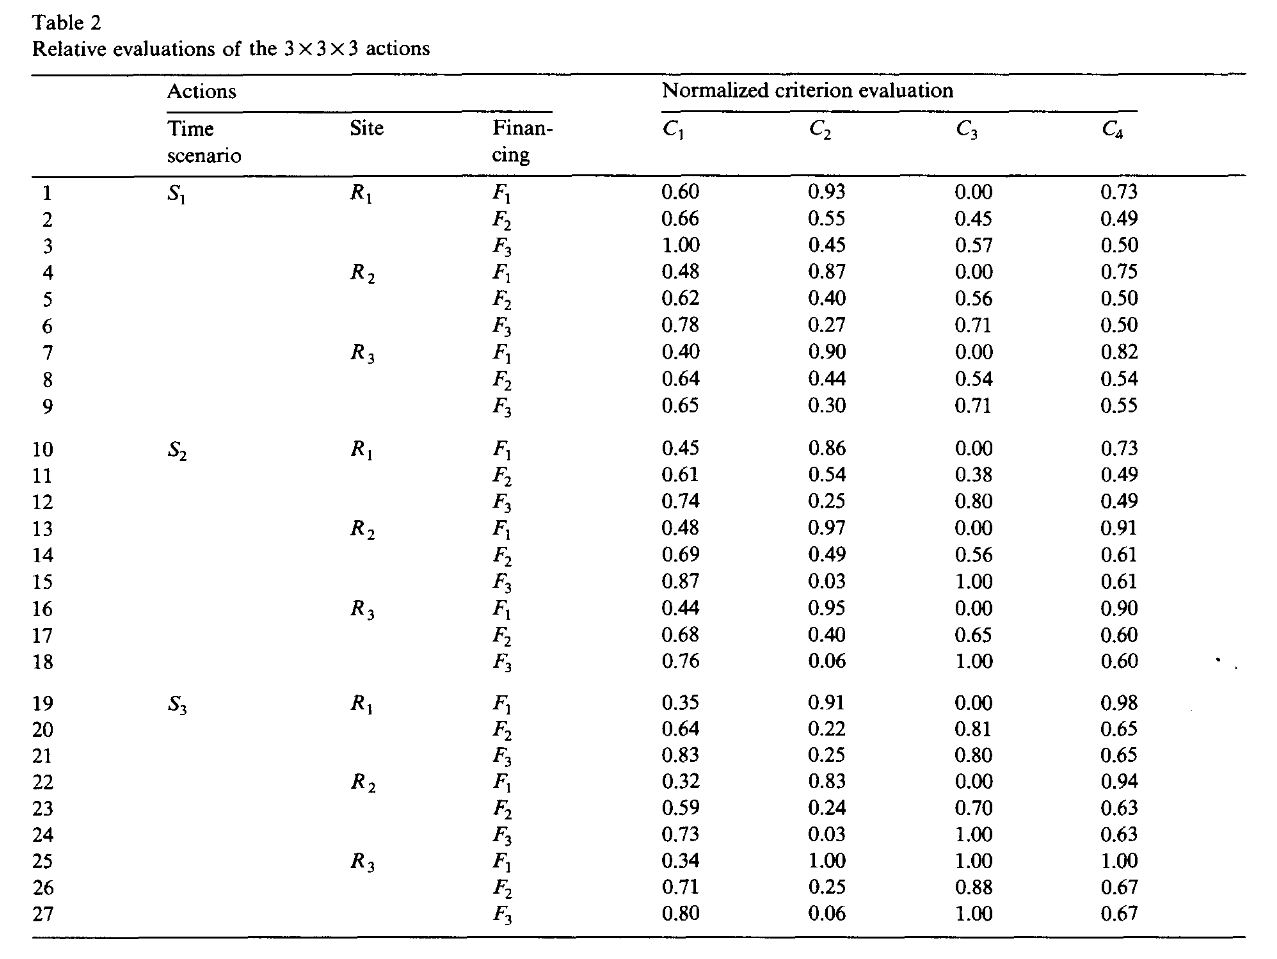

### Polityka firmy

Podczas tworzenia rankingu częściowego będziemy kierować się następującą polityką:

- Wydajność produkcji energii elektrycznej wzrośnie w przyszłości. Dodatkowo nie chcę brać pożyczek. (1)
- Preferowana jest lokalizacja R2 nad R1 oraz R1 nad R3. (4)

Drugi warunek jest łatwy do interpretacji - odnosi się jedynie do lokalizacji składowiska.

Pierwszy warunek odnosi się do czterech kryteriów. Chcemy minimalizować przede wszystkim wartość na kryterium C2. Optymistycznie podchodzimy do przyszłości - jesteśmy w stanie zaakceptować gorsze wartości na kryteriach C3 i C4.

### Pary wariantów referencyjnych

Utworzymy ranking częściowy poprzez porównanie parami następujących wariantów:

- 12 i 19
- 11 i 25
- 1 i 27
- 18 i 27
- 3 i 6


### Wczytanie danych


In [26]:
import pandas

data = pandas.read_csv("Nuclear waste management.csv")
data.columns = ["ID", "C1", "C2", "C3", "C4"]
display(data.style.hide())

ID,C1,C2,C3,C4
1,0.600000,0.930000,0.000000,0.730000
2,0.660000,0.550000,0.450000,0.490000
3,1.000000,0.450000,0.570000,0.500000
4,0.480000,0.870000,0.000000,0.750000
5,0.620000,0.400000,0.560000,0.500000
6,0.780000,0.270000,0.710000,0.500000
7,0.400000,0.900000,0.000000,0.820000
8,0.640000,0.440000,0.540000,0.540000
9,0.650000,0.300000,0.710000,0.550000
10,0.450000,0.860000,0.000000,0.730000


### Porównania parami

- 12 > 19, ponieważ warianty mają taką samą lokalizację (R1), a 12 ma dużo mniejszą wartość na kryterium C2
- 11 > 25, ponieważ preferujemy lokalizację R1 nad R3
- 1 > 27, ponieważ preferujemy lokalizację R1 nad R3, a ponadto 1 ma dużo mniejszą wartość na kryterium C2
- 18 ~ 27, ponieważ oba mają lokalizację R3, a także taką samą wartość na kryterium C2,
- 6 > 3, ponieważ preferujemy lokalizację R2 nad R1, a ponadto 6 ma mniejszą wartość na kryteriach C2 i C1.


## Solver UTA


In [27]:
!pip install pulp
from pulp import LpProblem, LpVariable, LpMaximize, lpSum, value, LpStatus

DEPRECATION: Loading egg at c:\users\miknowak\appdata\local\programs\python\python312\lib\site-packages\labelimg-1.8.6-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\miknowak\appdata\local\programs\python\python312\lib\site-packages\lxml-5.2.2-py3.12-win-amd64.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


### Definicja problemu


In [28]:
# definicja funkcji celu
prob = LpProblem("UTA", LpMaximize)
e = LpVariable(name="e", lowBound=0, upBound=1)
prob += e

# utworzenie zmiennych decyzyjnych dla kryteriów
criterion_vars = {}
for column in data:
    if column != "ID":
        criterion_vars[column] = {val: LpVariable(f"{column}_{val}", lowBound=0, upBound=1) for val in data[column].values}

# dodanie ograniczeń UTA
sum_max = 0
for column in data:
    if column != "ID":
        values = data[column].values.tolist()

        # monotoniczność
        values.sort()
        for i in range(len(values) - 1):
            prob += criterion_vars[column][values[i]] <= criterion_vars[column][values[i+1]], f"Monotonicity_{column}_{i}"

        # dodatkowe ograniczenie - minimalna waga kryterium 0.1
        min_val = min(values)
        prob += criterion_vars[column][min_val] == 0.1, f"Normalize_{column}_Lowest"

        # normalizacja - suma maksymalnych wartości równa 100
        max_val = max(values)
        sum_max += criterion_vars[column][max_val] 
prob += sum_max == 1, "Normalize_Criteria_Sum"

# utworzenie zmiennych definiujących użyteczność wariantów
utilities = []
utilities.append(0) # warianty są numerowane od 1
for i, variant in data.iterrows():
    u = LpVariable(f"U_{i+1}", lowBound=0)
    utilities.append(u)
    prob += u == lpSum([
        criterion_vars["C1"][variant["C1"]],
        criterion_vars["C2"][variant["C2"]],
        criterion_vars["C3"][variant["C3"]],
        criterion_vars["C4"][variant["C4"]]
    ]), f"Utility_{i+1}"

# dodanie ograniczeń z porównań parami
prob += utilities[12] >= utilities[19] + e, "Prefer_12_over_19"
prob += utilities[11] >= utilities[25] + e, "Prefer_11_over_25"
prob += utilities[1] >= utilities[27] + e, "Prefer_1_over_27"
prob += utilities[18] == utilities[27], "18_equal_27"
prob += utilities[6] >= utilities[3] + e, "Prefer_6_over_3"

In [29]:
prob

UTA:
MAXIMIZE
1*e + 0
SUBJECT TO
Monotonicity_C1_0: C1_0.32 - C1_0.34 <= 0

Monotonicity_C1_1: C1_0.34 - C1_0.35 <= 0

Monotonicity_C1_2: C1_0.35 - C1_0.4 <= 0

Monotonicity_C1_3: C1_0.4 - C1_0.44 <= 0

Monotonicity_C1_4: C1_0.44 - C1_0.45 <= 0

Monotonicity_C1_5: C1_0.45 - C1_0.48 <= 0

Monotonicity_C1_6: 0 C1_0.48 <= 0

Monotonicity_C1_7: C1_0.48 - C1_0.59 <= 0

Monotonicity_C1_8: C1_0.59 - C1_0.6 <= 0

Monotonicity_C1_9: C1_0.6 - C1_0.61 <= 0

Monotonicity_C1_10: C1_0.61 - C1_0.62 <= 0

Monotonicity_C1_11: C1_0.62 - C1_0.64 <= 0

Monotonicity_C1_12: 0 C1_0.64 <= 0

Monotonicity_C1_13: C1_0.64 - C1_0.65 <= 0

Monotonicity_C1_14: C1_0.65 - C1_0.66 <= 0

Monotonicity_C1_15: C1_0.66 - C1_0.68 <= 0

Monotonicity_C1_16: C1_0.68 - C1_0.69 <= 0

Monotonicity_C1_17: C1_0.69 - C1_0.71 <= 0

Monotonicity_C1_18: C1_0.71 - C1_0.73 <= 0

Monotonicity_C1_19: C1_0.73 - C1_0.74 <= 0

Monotonicity_C1_20: C1_0.74 - C1_0.76 <= 0

Monotonicity_C1_21: C1_0.76 - C1_0.78 <= 0

Monotonicity_C1_22: C1_0.78 -

### Rozwiązanie problemu


In [30]:
prob.solve()

1

In [31]:
import numpy as np

print(f"Status: {LpStatus[prob.status]}")
print("\nWartość funkcji celu:", value(prob.objective))

Status: Optimal

Wartość funkcji celu: 0.12


### Wartości użyteczności wariantów


In [32]:
import numpy as np

values = data["C1"].values.tolist()

ranking = [0 for i in range(len(values))]

for var in prob.variables():
    if var.name[0] == "U":
        number = int(var.name[2:])
        ranking[number-1] = value(var) 

is_reference = [0 for i in range(len(values))]
reference_variants = [0, 2, 5, 10, 11, 18, 24, 26]
for i in reference_variants:
    is_reference[i] = 1

data['U'] = ranking
data['Referencyjny'] = is_reference
display(data.style.hide())

ID,C1,C2,C3,C4,U,Referencyjny
1,0.600000,0.930000,0.000000,0.730000,0.880000,1
2,0.660000,0.550000,0.450000,0.490000,0.880000,0
3,1.000000,0.450000,0.570000,0.500000,0.640000,1
4,0.480000,0.870000,0.000000,0.750000,0.640000,0
5,0.620000,0.400000,0.560000,0.500000,0.640000,0
6,0.780000,0.270000,0.710000,0.500000,0.760000,1
7,0.400000,0.900000,0.000000,0.820000,0.640000,0
8,0.640000,0.440000,0.540000,0.540000,0.640000,0
9,0.650000,0.300000,0.710000,0.550000,0.760000,0
10,0.450000,0.860000,0.000000,0.730000,0.640000,0


### Wykresy cząstkowych funkcji użyteczności


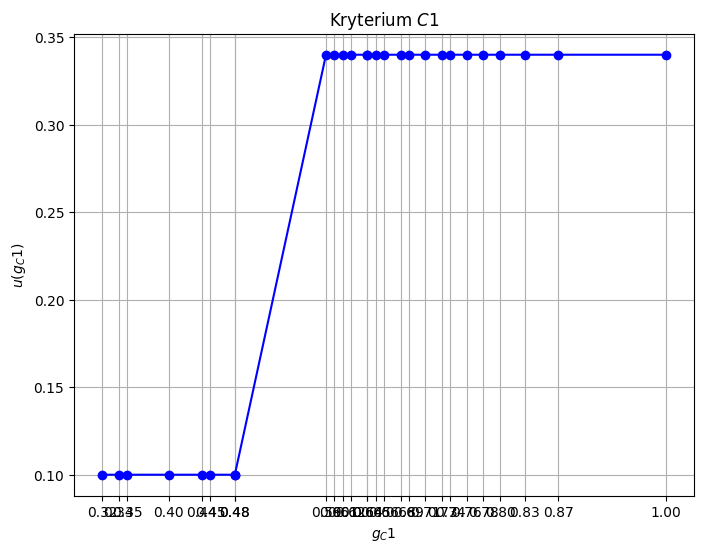

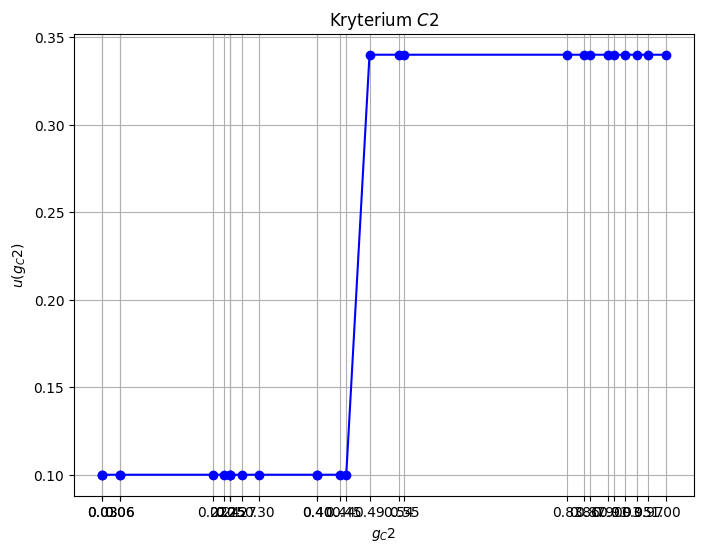

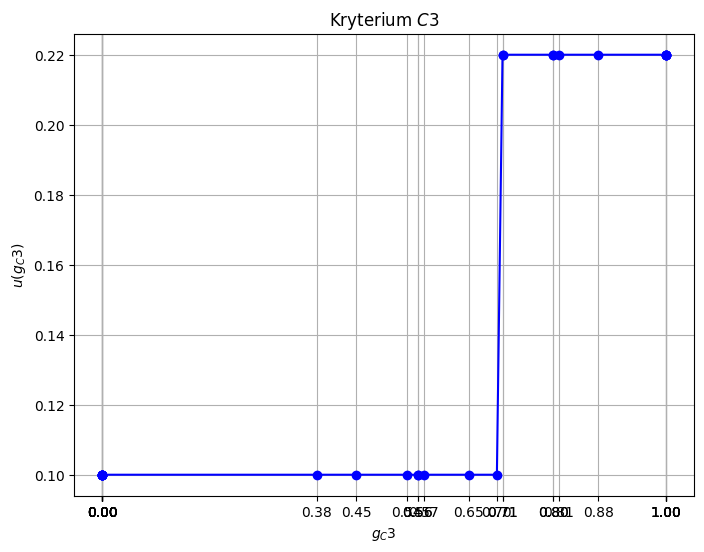

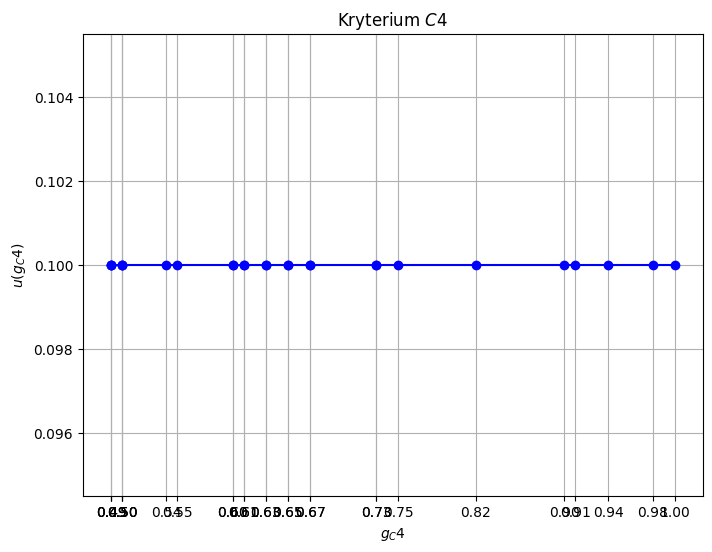

In [33]:
import matplotlib.pyplot as plt

for column in data.columns:
    if column in ["C1", "C2", "C3", "C4"]:
        values = data[column].values.tolist()
        values.sort()

        solver_values_C1 = [value(criterion_vars[column][val]) for val in values]

        plt.figure(figsize=(8, 6))
        plt.plot(values, solver_values_C1, marker='o', linestyle='-', color='b', label=f'$u(g_{column})$')
        plt.xlabel(f'$g_{column}$')
        plt.ylabel(f'$u(g_{column})$')
        plt.title(f'Kryterium ${column}$')
        plt.xticks(data[column].values)
        plt.grid(True)
        plt.show()

### Ranking końcowy


In [34]:
data = data.sort_values('U', ascending=False)
display(data.style.hide())

print(f"1. {data['U'][0]}: {data['ID'][0]}", end=" ")
place = 1

for i in range(1, len(data['U'])):
    if data['U'][i-1] == data['U'][i]:
        print(data['ID'][i], end=" ")
    else:
        place += 1
        print(f"\n{place}. {data['U'][i]}: {data['ID'][i]}", end=" ")

# TODO: diagram graphviz na podstawie rankingu
# FIXME: iteracja po U w dobrej kolejności??

ID,C1,C2,C3,C4,U,Referencyjny
1,0.600000,0.930000,0.000000,0.730000,0.880000,1
11,0.610000,0.540000,0.380000,0.490000,0.880000,1
2,0.660000,0.550000,0.450000,0.490000,0.880000,0
14,0.690000,0.490000,0.560000,0.610000,0.880000,0
27,0.800000,0.060000,1.000000,0.670000,0.760000,1
26,0.710000,0.250000,0.880000,0.670000,0.760000,0
25,0.340000,1.000000,1.000000,1.000000,0.760000,1
9,0.650000,0.300000,0.710000,0.550000,0.760000,0
24,0.730000,0.030000,1.000000,0.630000,0.760000,0
12,0.740000,0.250000,0.800000,0.490000,0.760000,1


1. 0.88: 1 2 
2. 0.64: 3 4 5 
3. 0.76: 6 
4. 0.64: 7 8 
5. 0.76: 9 
6. 0.64: 10 
7. 0.88: 11 
8. 0.76: 12 
9. 0.64: 13 
10. 0.88: 14 
11. 0.76: 15 
12. 0.64: 16 17 
13. 0.76: 18 
14. 0.64: 19 
15. 0.76: 20 21 
16. 0.64: 22 23 
17. 0.76: 24 25 26 27 

In [35]:
!sudo apt install graphviz
!pip install graphviz
from graphviz import Digraph

Sudo is disabled on this machine. To enable it, go to the ]8;;ms-settings:developers\Developer Settings page]8;;\ in the Settings app


DEPRECATION: Loading egg at c:\users\miknowak\appdata\local\programs\python\python312\lib\site-packages\labelimg-1.8.6-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\miknowak\appdata\local\programs\python\python312\lib\site-packages\lxml-5.2.2-py3.12-win-amd64.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [36]:
def rank_and_visualize(data):
    # Sort the data by 'U' in descending order
    data = data.sort_values('U', ascending=False)

    # Print ranking
    print(f"1. {data['U'].iloc[0]}: {data['ID'].iloc[0]}", end=" ")
    place = 1
    ranking_nodes = {data['U'].iloc[0]: [str(data['ID'].iloc[0])]}  # Dictionary to store rankings for visualization

    for i in range(1, len(data['U'])):
        if data['U'].iloc[i-1] == data['U'].iloc[i]:
            print(data['ID'].iloc[i], end=" ")
            ranking_nodes[data['U'].iloc[i]].append(str(data['ID'].iloc[i]))
        else:
            place += 1
            print(f"\n{place}. {data['U'].iloc[i]}: {data['ID'].iloc[i]}", end=" ")
            ranking_nodes[data['U'].iloc[i]] = [str(data['ID'].iloc[i])]

    # Create Graphviz diagram
    dgraph = Digraph(format="png")
    dgraph.attr(rankdir="TB")  # Top to bottom layout

    prev_node = None
    for U_value, ids in ranking_nodes.items():
        node_label = f"U = {U_value}: " + ", ".join(ids)  # IDs separated by commas
        node_name = f"U_{U_value}"
        dgraph.node(node_name, label=node_label, shape="box", style="filled", fillcolor="lightblue")

        if prev_node:
            dgraph.edge(prev_node, node_name)  # Connect utility levels

        prev_node = node_name  # Update previous node for linking

    display(dgraph)

1. 0.88: 1 2 14 11 
2. 0.76: 12 18 6 15 21 20 24 25 26 27 9 
3. 0.64: 13 7 8 10 4 5 3 17 22 23 19 16 

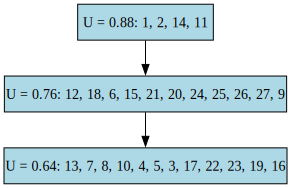

In [37]:
rank_and_visualize(data)

## Analiza wyników


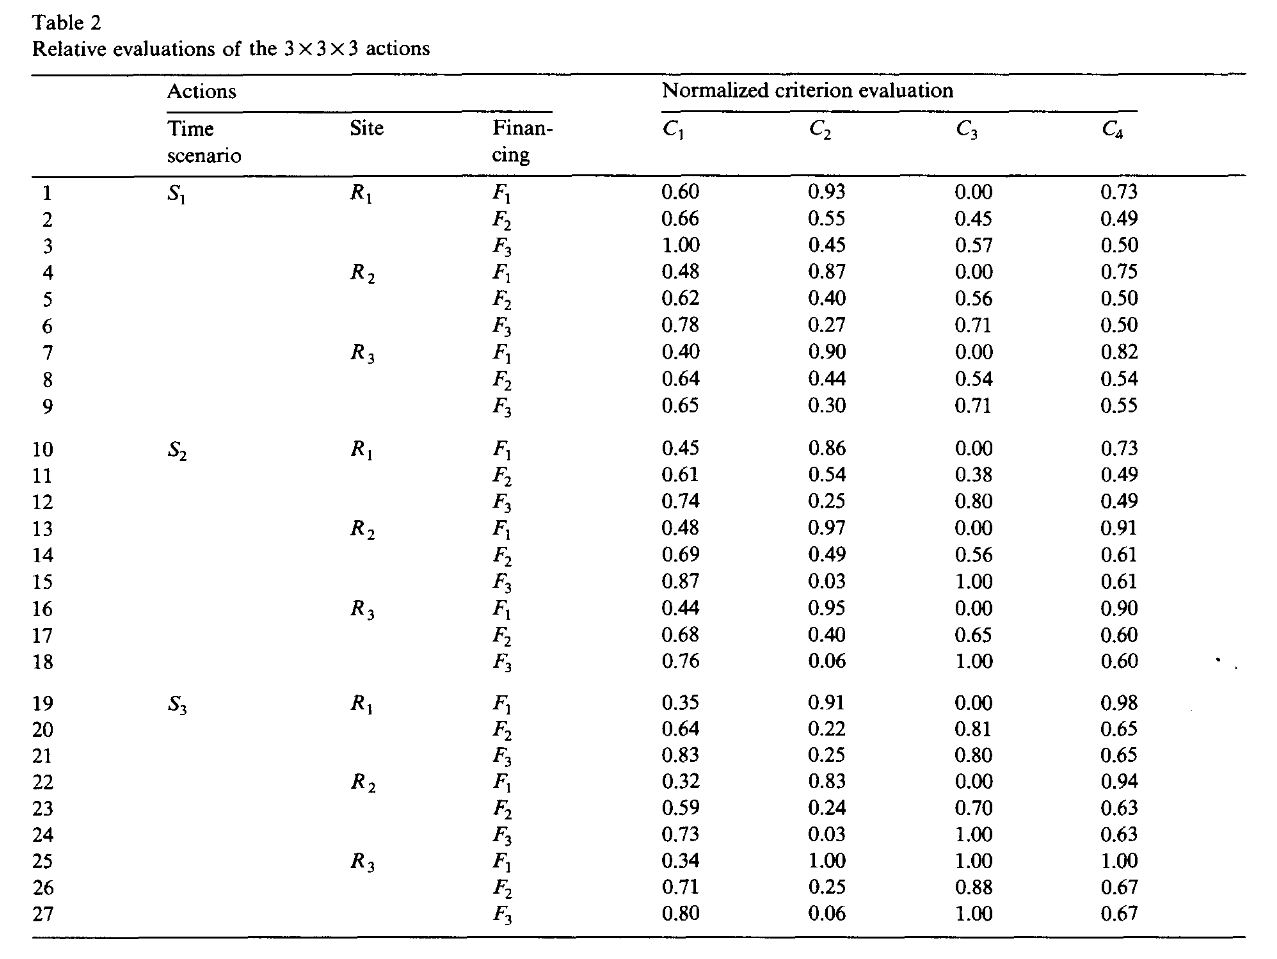


Uzyskany ranking jest zgodny z rankingiem częściowym podanym w ramach informacji preferencyjnej.

- U(12) = 0.76 i U(19) = 0.64, zatem 12 > 19
- U(11) = 0.88 i U(25) = 0.76, zatem 11 > 25
- U(1) = 0.88 i U(27) = 0.76, zatem 1 > 27
- U(18) = 0.76 i U(27) = 0.76, zatem 18 ~ 27
- U(6) = 0.76 i U(3) = 0.64, zatem 6 > 3

Warianty niereferencyjne również uporządkowane są zgodnie z informacją preferencyjną.

[przykłady]

Najlepszą ocenę uzyskały cztery strategie:

- 1: S1 x R1 x F1
- 2: S1 x R1 x F2
- 11: S2 x R1 x F2
- 14: S2 x R2 x F2

Największy wpływ na końcowy wynik miały kryteria C1 i C2. Najmniejszy wpływ miało kryterium C4, które dla wszystkich wartości ma minimalną wagę 0.1.
